In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

In [4]:
data = pd.read_csv('bank_featured.csv')
data.head()

,duration,poutcome_success,month_oct,contact_unknown,month_mar,month_jan,day,month_nov,month_jul,loan_yes,marital_married,poutcome_other,month_sep,job_retired,y_yes
0,79,0,1,0,0,0,19,0,0,0,1,0,0,0,0
1,220,0,0,0,0,0,11,0,0,1,1,0,0,0,0
2,185,0,0,0,0,0,16,0,0,0,0,0,0,0,0
3,199,0,0,1,0,0,3,0,0,1,1,0,0,0,0
4,226,0,0,1,0,0,5,0,0,0,1,0,0,0,0


In [5]:
data['y_yes'].value_counts()/len(data)

0    0.88476
1    0.11524
Name: y_yes, dtype: float64

# Up-Sampling

In [6]:
# split the data into two parts
# sample = 0 and sample = 1
data_no  = data[data['y_yes']==0]
data_yes = data[data['y_yes']==1]

In [7]:
from sklearn.utils import resample

In [8]:
data_yes_resample = resample(data_yes,replace=True,n_samples=2000)

In [9]:
# concatenate data_no and data_yes_resample
data_resampe = pd.concat((data_no,data_yes_resample),axis=0)

In [10]:
data_resampe['y_yes'].value_counts()

0    4000
1    2000
Name: y_yes, dtype: int64

**Indendent and Dependent Variables**

In [11]:
X = data_resampe.iloc[:,:-1]# independent variable
y = data_resampe.iloc[:,-1] # dependent variable

In [12]:
# spliting into training and testing
np.random.seed(1001)
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((4200, 14), (1800, 14), (4200,), (1800,))

**Building Machine Learning Model**

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [15]:
model.fit(x_train,y_train) # training

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

**Maximum Likehood Estimation**

In [16]:
# traning data
y_pred_train = model.predict_proba(x_train)
y_pred_train_1 = y_pred_train[:,1]

In [17]:
from sklearn.metrics import log_loss
class threshold():
    def __init__(self):
        self.th = 0.5
        
    def predict_threshold(self,y):
        if y >= self.th:
            return 1
        else:
            return 0

In [18]:
y_pred_train_prob_1 =y_pred_train_1
probailites = np.linspace(0,1,num = 100) # generating 100 values in 0 -1 
pre = threshold() # initializing class
mle = [] 
for p in probailites:
    pre.th = p
    yy = pd.Series(y_pred_train_prob_1)
    y_pred_0_5 =yy.apply(pre.predict_threshold)
    loss = log_loss(y_train,y_pred_0_5)
    mle.append(loss)

Threshold Probability Value = 0.4040404040404041


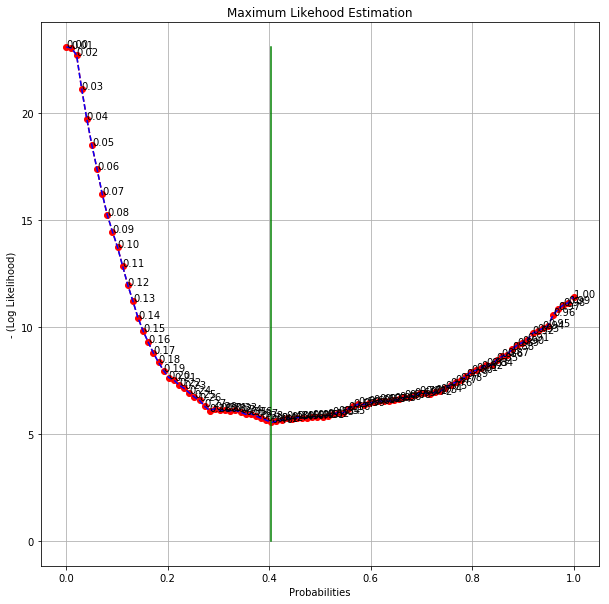

In [19]:
# visualize
plt.figure(figsize=(10,10))
plt.plot(probailites,mle,'ro--')
plt.plot(probailites,mle,'b--')
ind = np.array(mle).argmin()
mx = max(mle)
val = probailites[ind]

print('Threshold Probability Value =',val)

plt.plot([val,val],[0,mx],'g')


for i,p in enumerate(probailites):
    plt.text(probailites[i],mle[i],'%0.2f'%(p))


plt.xlabel('Probabilities')
plt.ylabel('- (Log Likelihood)')
plt.title('Maximum Likehood Estimation')
plt.grid()
plt.show()

#### Apply to test data

In [20]:
y_pred_prob_test = model.predict_proba(x_test)
y_pred_prob_test_1 = y_pred_prob_test[:,1] # array (numpy)

In [21]:
pre = threshold() # Predictor class
threh_prob = 0.4748 # from MLE
pre.th = threh_prob # setting threshold
yy = pd.Series(y_pred_prob_test_1) # convtering prob array into series
y_pred_class_test =yy.apply(pre.predict_threshold) # apply predictor class

# Statistical Evaluation

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

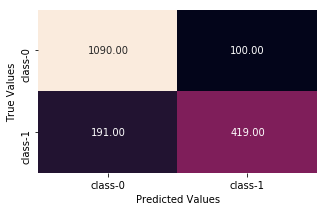

In [23]:
cm = confusion_matrix(y_test,y_pred_class_test)
plt.figure(figsize=(5,3))

sns.heatmap(cm,annot=True,fmt='0.2f',xticklabels=['class-0','class-1'],
           yticklabels=['class-0','class-1'],cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

In [24]:
cr = classification_report(y_test,y_pred_class_test)
print(cr)

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1190
           1       0.81      0.69      0.74       610

   micro avg       0.84      0.84      0.84      1800
   macro avg       0.83      0.80      0.81      1800
weighted avg       0.84      0.84      0.83      1800



In [25]:
from sklearn.metrics import cohen_kappa_score

In [26]:
cohen_kappa_score(y_test,y_pred_class_test)

0.625595059398722

In [28]:
ra = (1190/1800)*(1092/1800) + (610/1800)*(419/1800)
acc = (1092+419) / 1800
ra, acc

(0.4799598765432099, 0.8394444444444444)

In [30]:
kappa = (acc - ra)/(1-ra)
kappa

0.69126313852801

### ROC and AUC (Traning Data)
- ROC: Receiver Operating Characterstic
- AUC: Area under the curve

In [31]:
from sklearn.metrics import roc_curve, auc

In [33]:
y_pred_train_prob = model.predict_proba(x_train)
y_pred_train_prob1 = y_pred_train_prob[:,1]

In [34]:
fpr,tpr,proba = roc_curve(y_train,y_pred_train_prob1)

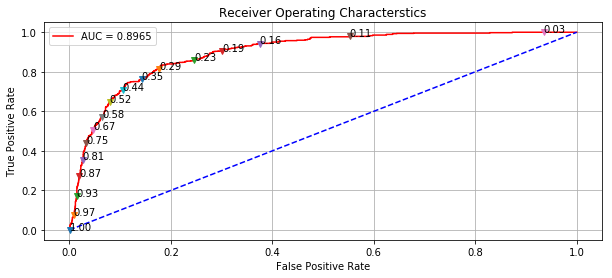

In [57]:
plt.figure(figsize=(10,4))
plt.plot(fpr,tpr,'r-')
plt.plot([0,1],[0,1],'b--')
for i in range(len(proba)):
    if i % 50 == 1: # display for every 5th value
        plt.plot(fpr[i],tpr[i],'v')
        plt.text(fpr[i],tpr[i],'%0.2f'%proba[i])
        
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characterstics')
area = auc(fpr,tpr)
plt.legend(['AUC = %0.4f'%area])
plt.grid()

In [53]:
auc(fpr,tpr)

0.8964554904119407

In [58]:
pre = threshold() # Predictor class
threh_prob = 0.3 # from ROC
pre.th = threh_prob # setting threshold
yy = pd.Series(y_pred_train_prob1) # convtering prob array into series
y_pred_class_train =yy.apply(pre.predict_threshold) # apply predictor class

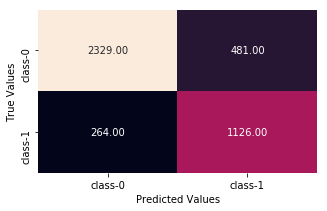

In [59]:
cm = confusion_matrix(y_train,y_pred_class_train)
plt.figure(figsize=(5,3))

sns.heatmap(cm,annot=True,fmt='0.2f',xticklabels=['class-0','class-1'],
           yticklabels=['class-0','class-1'],cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

In [60]:
cr = classification_report(y_train,y_pred_class_train)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      2810
           1       0.70      0.81      0.75      1390

   micro avg       0.82      0.82      0.82      4200
   macro avg       0.80      0.82      0.81      4200
weighted avg       0.83      0.82      0.83      4200



In [61]:
cohen_kappa_score(y_train,y_pred_class_train)

0.6146523250171799